# March Machine Learning Mania 2025
### © 2025 Prutha Annadate 

*Aim*: To make predictions about every possible matchup in the tournament, evaluated using the Brier score. 

Before undergoing analysis, we'll find the relationships between the tables given to us. We have 36 files in total, but broadly they can be classified into tables containing data about men and women. Some data differs between the men and women teams, we will analyze the teams separately using different metrics, if required. 

The Entity Relationship (ER) diagram is a visual on how the relations exist between the varioud data sources. The ER as seen below has been coded on [dbdiagram.io](https://dbdiagram.io/home). 


<span style="font-size:18px;"> Men's Team ER </span>
# 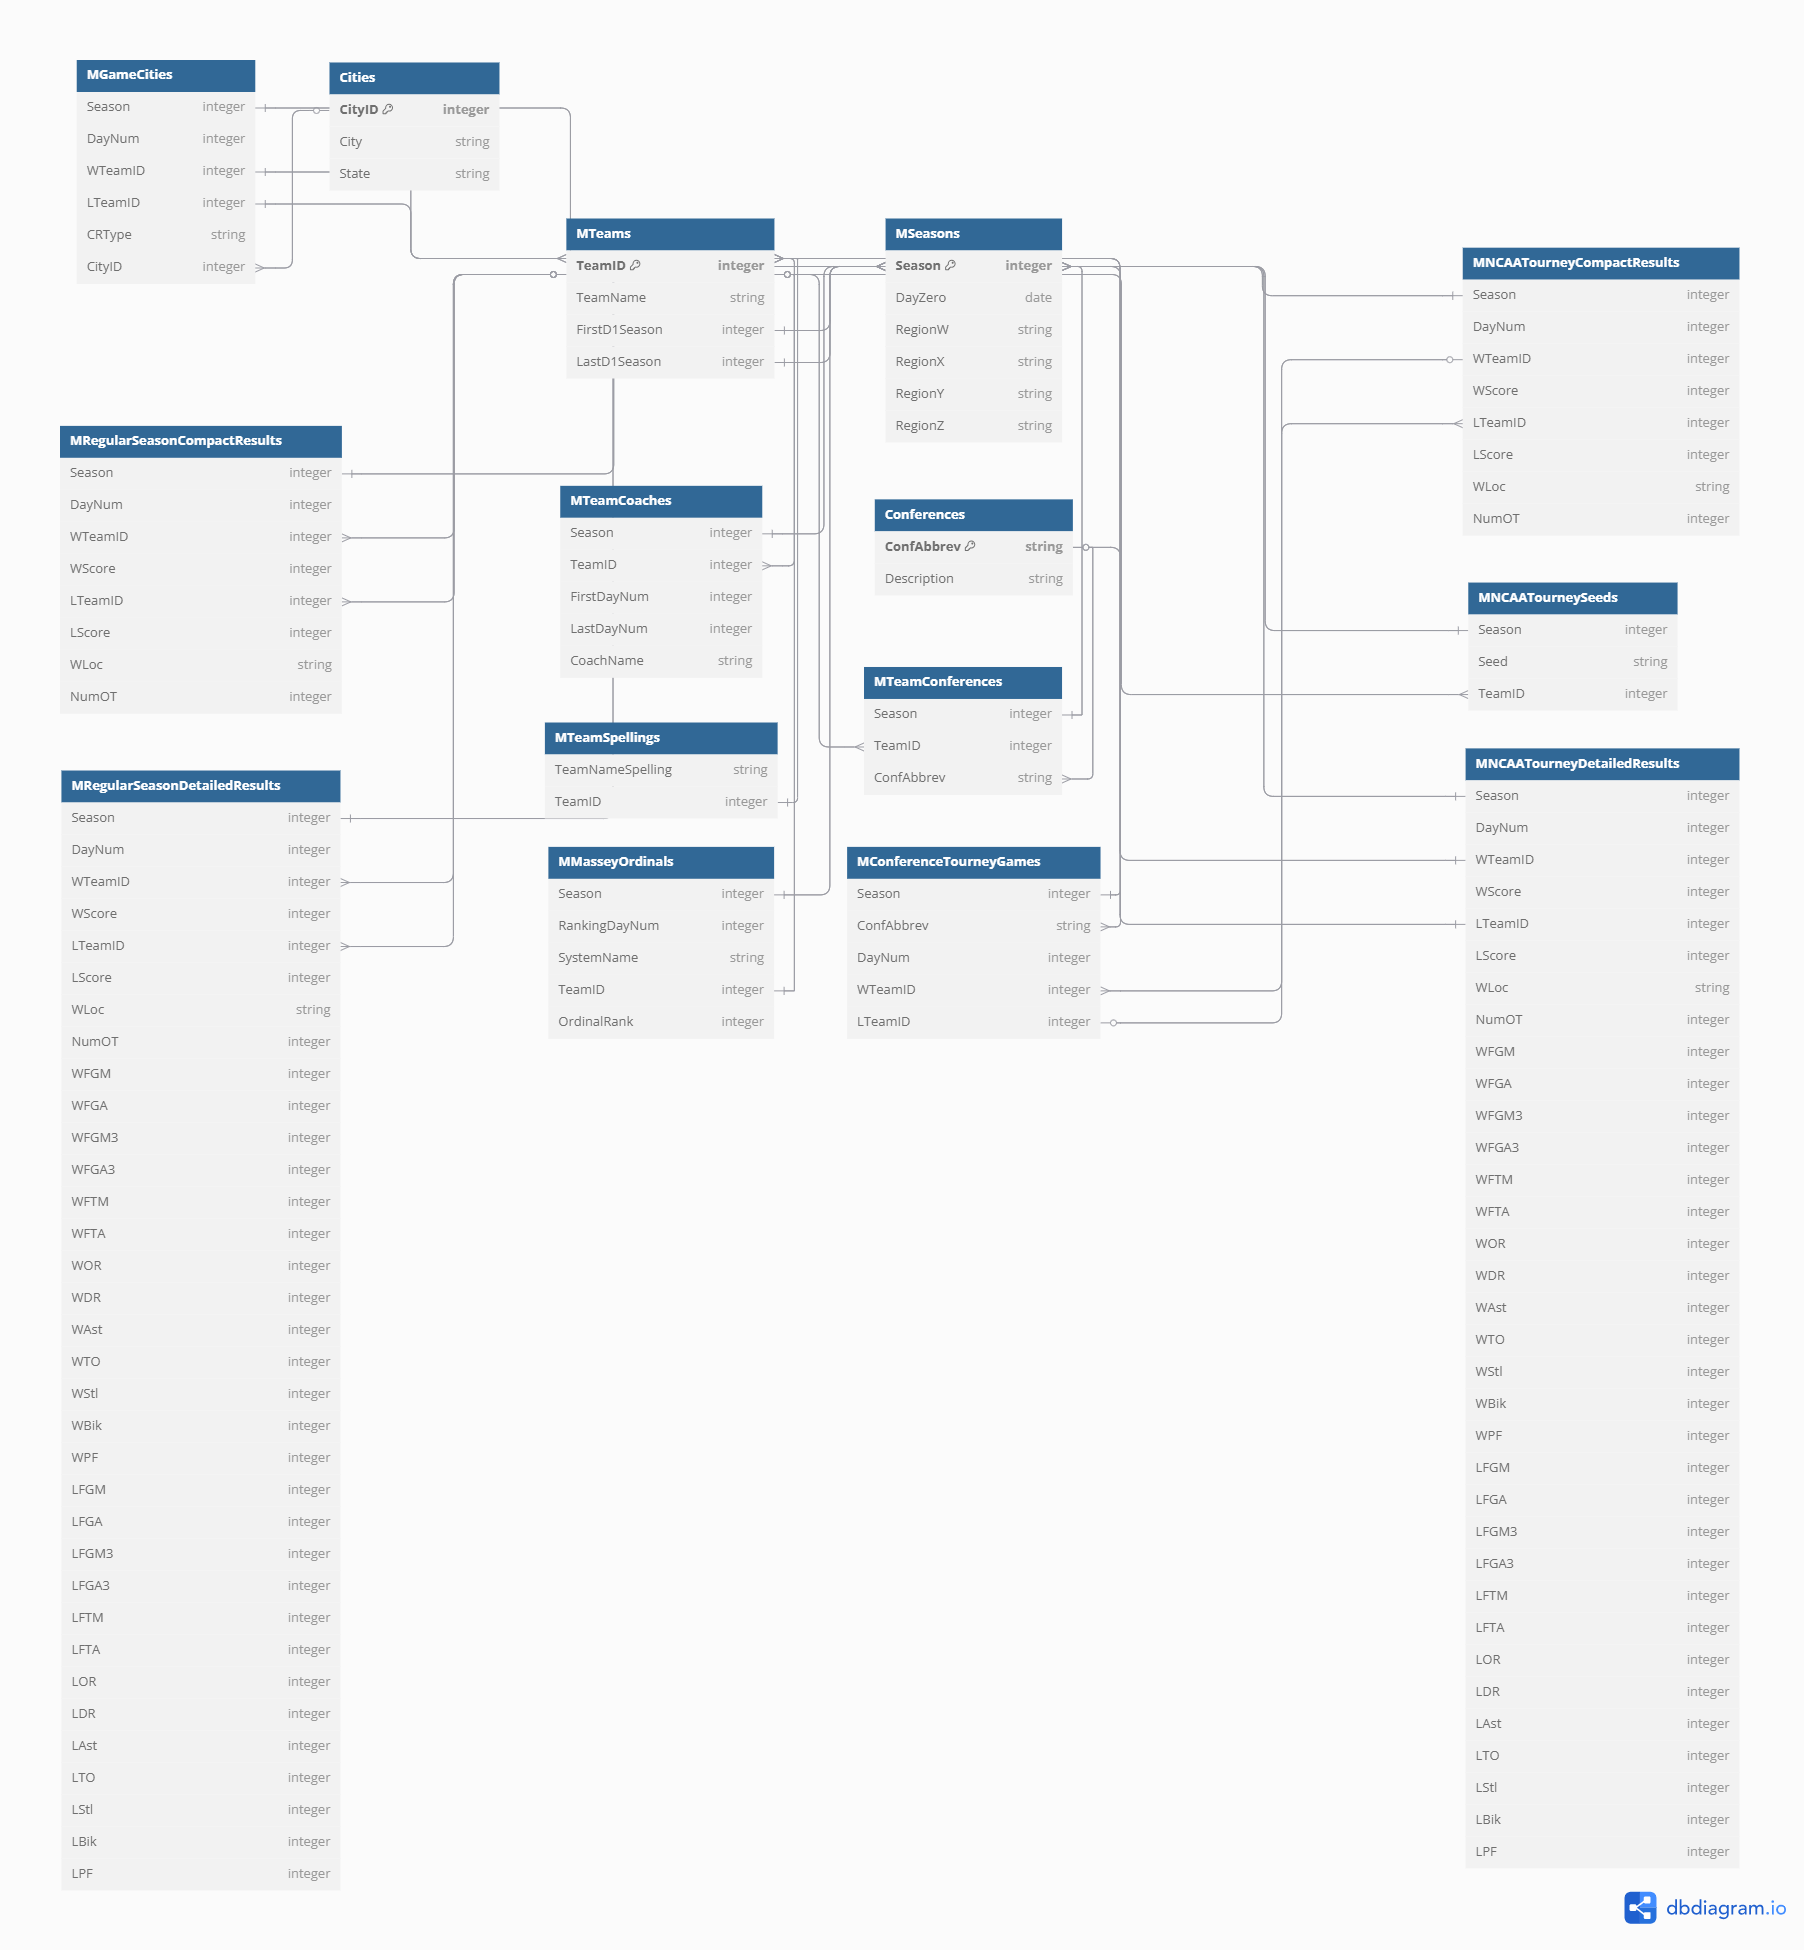[](http://)


## Bracket Prediction

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

# Define input folder path
input_folder = r"./kaggle/input/march-machine-learning-mania-2025"

# List of relevant data files
mens_files = ["MNCAATourneyCompactResults.csv", "MRegularSeasonCompactResults.csv", "MTeams.csv"]
womens_files = ["WNCAATourneyCompactResults.csv", "WRegularSeasonCompactResults.csv", "WTeams.csv"]

dataframes = {}

def load_csv_files(file_list):
    for file in file_list:
        file_path = os.path.join(input_folder, file)
        key = os.path.splitext(file)[0]
        try:
            dataframes[key] = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error loading {file}: {e}")

# Load data
load_csv_files(mens_files)
load_csv_files(womens_files)
# Preprocess data
def preprocess_results(df):
    df = df[['Season', 'WTeamID', 'LTeamID']].copy()
    df.loc[:, 'Result'] = 1  # Win label
    df_inv = df.copy()
    df_inv[['WTeamID', 'LTeamID']] = df[['LTeamID', 'WTeamID']].values
    df_inv.loc[:, 'Result'] = 0  # Loss label
    return pd.concat([df, df_inv], ignore_index=True)

men_results = preprocess_results(dataframes['MNCAATourneyCompactResults'])
women_results = preprocess_results(dataframes['WNCAATourneyCompactResults'])

# Merge men's and women's datasets
all_results = pd.concat([men_results, women_results], ignore_index=True)
print(men_results.tail(50))



      Season  WTeamID  LTeamID  Result
4986    2024     1389     1397       0
4987    2024     1161     1400       0
4988    2024     1179     1450       0
4989    2024     1158     1104       0
4990    2024     1159     1124       0
4991    2024     1307     1155       0
4992    2024     1196     1160       0
4993    2024     1391     1163       0
4994    2024     1436     1181       0
4995    2024     1388     1213       0
4996    2024     1255     1222       0
4997    2024     1458     1241       0
4998    2024     1443     1266       0
4999    2024     1194     1321       0
5000    2024     1212     1345       0
5001    2024     1412     1361       0
5002    2024     1304     1401       0
5003    2024     1395     1429       0
5004    2024     1120     1463       0
5005    2024     1173     1112       0
5006    2024     1332     1166       0
5007    2024     1242     1211       0
5008    2024     1182     1228       0
5009    2024     1450     1235       0
5010    2024     1324    

In [ ]:


# Train model
X = all_results[['Season', 'WTeamID', 'LTeamID']]
y = all_results['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=200)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate model
preds = model.predict_proba(X_test)[:, 1]
print(f"Brier Score: {brier_score_loss(y_test, preds)}")

# Generate submission
all_teams = np.concatenate((dataframes['MTeams']['TeamID'].values, dataframes['WTeams']['TeamID'].values))
pairings = list(combinations(all_teams, 2))

# Load required matchup IDs
required_ids_df = pd.read_csv(os.path.join(input_folder, "SampleSubmissionStage2.csv"))
required_ids = set(required_ids_df['ID'])

def create_submission(pairings, season=2025, max_rows=131407):
    submission = []
    for (team1, team2) in pairings:
        matchup_id = f"{season}_{min(team1, team2)}_{max(team1, team2)}"
        if matchup_id in required_ids:
            input_data = pd.DataFrame({'Season': [season], 'WTeamID': [min(team1, team2)], 'LTeamID': [max(team1, team2)]})
            pred = model.predict_proba(input_data)[0, 1] if len(input_data) > 0 else 0.5
            submission.append([matchup_id, pred])
    submission_df = pd.DataFrame(submission, columns=["ID", "Pred"])
    print(f"Submission file has {submission_df.shape[0]} rows.")
    return submission_df

submission_df = create_submission(pairings)
submission_df.to_csv("submission.csv", index=False)
print("Submission file created successfully.")

# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(submission_df['Pred'], bins=50, kde=True)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.show()
